In [11]:
import os, cv2, copy
import numpy as np
from util import parseMKV, exportCalib, tcp2base, target2cam_color, composeH
from visualizer import CameraPoseVisualizer
from scipy.spatial.transform import Rotation

os.chdir(globals()['_dh'][0])

In [12]:
dir = "./color"
out_dir = "./calib"

debug = True

exportFrames = False
exportCalibration = True
exportRobotPose = True
exportPoseEstimation = True

In [13]:
if exportCalibration:
    mtx, dist = exportCalib(dir = dir, debug = debug)
else:
    data = np.load("%s/calibration.npz" % dir)
    
    mtx = data["mtx"]
    dist = data["dist"]

if exportFrames:
    parseMKV(dir = dir, exportDepth = False, debug = debug)

if exportRobotPose:
    t_tcp2base, rVec_tcp2base, rMat_tcp2base, q_tcp2base = tcp2base(dir = dir)
else:
    data = np.load("%s/tcp2base.npz" % dir)

    t_tcp2base = data["t"]
    rVec_tcp2base = data["rVec"]
    rMat_tcp2base = data["rMat"]
    q_tcp2base = data["q"]
if exportPoseEstimation:
    rVec_target2cam, rMat_target2cam, t_target2cam, failedIdx = target2cam_color(dir = dir, mtx = mtx, dist = dist,
                                                                rx=copy.deepcopy(rVec_tcp2base),
                                                                tx=copy.deepcopy(t_tcp2base), 
                                                                boardDim = 30.45, boardSize = (24,17), debug = debug)
else:
    data = np.load("%s/target2cam.npz" % dir)
    
    t_target2cam = data["t"]
    rVec_target2cam = data["rVec"]
    rMat_target2cam = data["rMat"]

    failedIdx = data["failedIdx"]

Camera Matrix:
 [[1949.5269775390625, 0.0, 2038.583251953125], [0.0, 1948.865966796875, 1558.489013671875], [0.0, 0.0, 1.0]]
Distortion Coefficients:
 [0.5040435194969177, -2.6585097312927246, 0.0013027479872107506, -0.0005786155234090984, 1.516607642173767, 0.3857000470161438, -2.4865224361419678, 1.4463715553283691]
Estimating pose for image   0...Done!
Estimating pose for image   1...Done!
Estimating pose for image   2...Done!
Estimating pose for image   3...Done!
Estimating pose for image   4...Done!
Estimating pose for image   5...Done!
Estimating pose for image   6...Done!
Estimating pose for image   7...Done!
Estimating pose for image   8...Failed!
Estimating pose for image   9...Done!
Estimating pose for image  10...Done!
Estimating pose for image  11...Done!
Estimating pose for image  12...Done!
Estimating pose for image  13...Done!
Estimating pose for image  14...Done!
Estimating pose for image  15...Done!
Estimating pose for image  16...Done!
Estimating pose for image  17...

In [14]:
handEyeMethod = 4

methods = [cv2.CALIB_HAND_EYE_TSAI, cv2.CALIB_HAND_EYE_PARK, cv2.CALIB_HAND_EYE_HORAUD, cv2.CALIB_HAND_EYE_ANDREFF, cv2.CALIB_HAND_EYE_DANIILIDIS]
methods_s = ["tsai", "park", "horaud", "andreff", "daniilidis"]

R_tcp2base = rVec_tcp2base
R_target2cam = rVec_target2cam

R_tcp2base = np.delete(R_tcp2base, failedIdx, 0)
t_tcp2base = np.delete(t_tcp2base, failedIdx, 0)

R_results = []
t_results = []

for i in range(len(methods)):
    R_cam2tcp, t_cam2tcp = cv2.calibrateHandEye(R_tcp2base, t_tcp2base, R_target2cam, t_target2cam, method=methods[i])
    R_results.append(R_cam2tcp)
    t_results.append(t_cam2tcp)
    # output results
    print("--------------------------------------")
    print("Method %s" % methods_s[i])
    print("Rotation:\n", R_cam2tcp)
    print("Translation:\n", t_cam2tcp.ravel())
    print("Saving Method: %s..." % methods_s[i], end="")
    np.save("%s/cam2tcp_%s_color" % (out_dir, methods_s[i]), composeH(R_results[i], t_results[i]))
    print("Done!")
print("--------------------------------------")
print("Saving All Methods...", end="")
np.savez("%s/_cam2tcp_color" % out_dir, tsai=composeH(R_results[0], t_results[0]),
                                       park=composeH(R_results[1], t_results[1]),
                                       horaud=composeH(R_results[2], t_results[2]),
                                       andreff=composeH(R_results[3], t_results[3]),
                                       daniilidis=composeH(R_results[4], t_results[4]))
print("Done!")

--------------------------------------
Method tsai
Rotation:
 [[ 9.99990473e-01 -4.36377607e-03  1.02808149e-04]
 [ 4.36091177e-03  9.99797242e-01  1.96585344e-02]
 [-1.88572745e-04 -1.96578988e-02  9.99806747e-01]]
Translation:
 [ 0.53452392  0.18173034 -9.63793892]
Saving Method: tsai...Done!
--------------------------------------
Method park
Rotation:
 [[ 9.99990476e-01 -4.36309354e-03  1.09218947e-04]
 [ 4.36010254e-03  9.99797164e-01  1.96626665e-02]
 [-1.94986847e-04 -1.96620031e-02  9.99806665e-01]]
Translation:
 [ 0.53065989  0.18053293 -9.63802132]
Saving Method: park...Done!
--------------------------------------
Method horaud
Rotation:
 [[ 9.99990473e-01 -4.36379777e-03  1.02813293e-04]
 [ 4.36093336e-03  9.99797241e-01  1.96585401e-02]
 [-1.88578340e-04 -1.96579044e-02  9.99806747e-01]]
Translation:
 [ 0.53452037  0.18172889 -9.63793921]
Saving Method: horaud...Done!
--------------------------------------
Method andreff
Rotation:
 [[ 9.99987346e-01 -5.02270350e-03 -2.842903

initialize camera pose visualizer


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
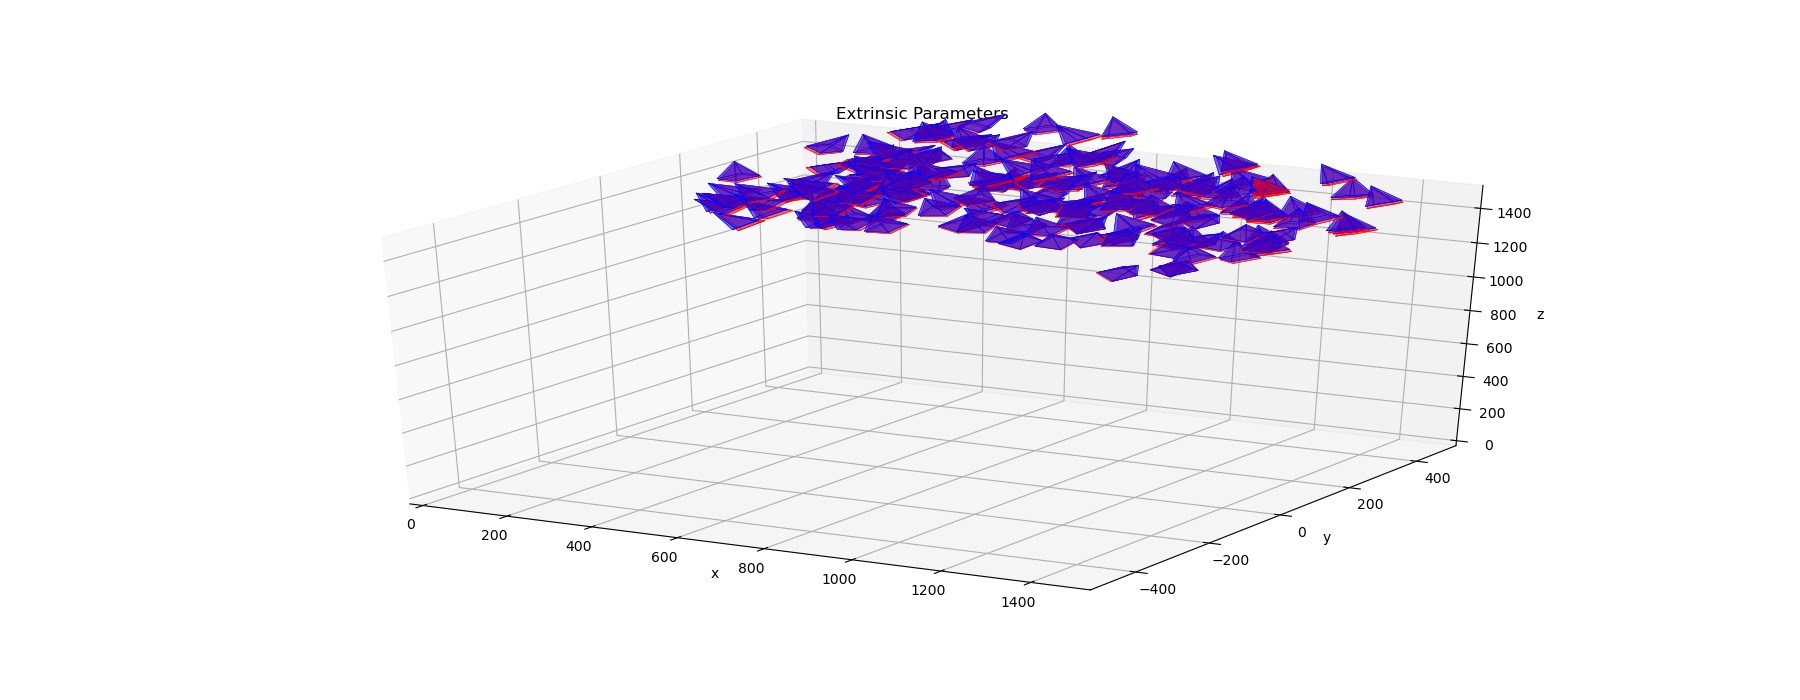

In [15]:
%matplotlib widget

visualizer = CameraPoseVisualizer([0, 1500], [-500, 500], [0, 1500])

cam2base = []

M_cam2tcp = composeH(R_results[handEyeMethod], t_results[handEyeMethod])
for i in range(len(t_tcp2base)):
    M_tcp2base = composeH(rMat_tcp2base[i], t_tcp2base[i])
    M_cam2base = np.matmul(M_tcp2base,M_cam2tcp)

    cam2base.append(M_cam2base)

    visualizer.extrinsic2pyramid(M_tcp2base, 'r', 100)
    visualizer.extrinsic2pyramid(M_cam2base, 'b', 100)
visualizer.show()

np.savez("%s/%s" % (dir, "cam2base"), cam2base)